# 7. RNNs

At the end of this exercise you will know how to:

* Perform character-level classification with a Recurrent Neural Network

And most importantly, you should gain a much better feeling for typical sequence modeling pipelines. The trained model will be able to predict which language a name originates from.

We first have to begin by downloading the data

In [1]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2023-01-25 15:47:57--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 2600:9000:237d:4800:d:607e:4540:93a1, 2600:9000:237d:7800:d:607e:4540:93a1, 2600:9000:237d:a000:d:607e:4540:93a1, ...
Connecting to download.pytorch.org (download.pytorch.org)|2600:9000:237d:4800:d:607e:4540:93a1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  1.60MB/s    in 1.7s    

2023-01-25 15:47:59 (1.60 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflatin

Getting a dictionary, we then need to process the data

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']


With this we now also have the number of categories in `n_categories`, and the complete list of considered languages in `all_languages`. Having this ASCII-stored data, we need to convert it into [PyTorch Tensors](https://pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html), and represent them as "one-hot vectors". What is a one-hot vector?

* Consider the task of encoding the letter "b" in a one-hot vector. Then the direct solution would be to have a vector of the length of the alphabet with 0's everywhere except at the 2nd position, where "b" is in the alphabet. This would constitute a one-hot encoding.

In [3]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


Writing an RNN out as a combination of two feedforward layers

In [4]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

Recalling from the lecture, we then feed the network with a prompt tensor, $x$ in the lecture, and then keeping the output token, as well as the altered hidden state which we would need at the next step to continue the computation. Every item will now contain the likelihood of a specific category.

In [6]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8554, -2.9434, -2.8635, -2.9034, -2.8198, -3.0112, -2.9386, -2.8283,
         -2.8667, -2.8405, -2.9416, -2.8832, -2.8567, -2.8561, -2.9914, -2.7951,
         -2.9989, -2.8679]], grad_fn=<LogSoftmaxBackward0>)


We will then need a few last helper functions to instigate the training

In [7]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Dutch', 15)


In [8]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = French / line = Porcher
category = Czech / line = Savchak
category = Portuguese / line = Melo
category = Russian / line = Kalaberda
category = Vietnamese / line = Truong
category = Polish / line = Maslanka
category = Greek / line = Kouros
category = English / line = Holdsworth
category = Czech / line = Schlantz
category = Greek / line = Tassioglou


With which we can then set up the training where each loop of the training will:

1. Create input and target tensors
2. Create a zeroed initial hidden state
3. Reach each letter in, and retain the hidden state for the next lettero
4. Compare the final output to the target output
5. Back-propagate the loss
6. Return the output and the loss

In [11]:
criterion = nn.NLLLoss()

In [9]:
learning_rate = 0.005
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Now we can the actual timed training and keep track of its returned losses of which we only print every 1000th step.

In [12]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 1s) 1.9192 Dubanowski / Italian ✗ (Polish)
10000 10% (0m 3s) 3.2465 Alexander / German ✗ (Scottish)
15000 15% (0m 5s) 0.4875 Sniegowski / Polish ✓
20000 20% (0m 6s) 1.3725 Gu / Vietnamese ✗ (Korean)
25000 25% (0m 8s) 0.8463 Chu / Vietnamese ✓
30000 30% (0m 10s) 1.6752 Marmo / Portuguese ✗ (Italian)
35000 35% (0m 11s) 1.3022 Cleirich / Irish ✓
40000 40% (0m 13s) 0.7217 Nolan / Irish ✓
45000 45% (0m 15s) 1.8031 Aiza / Japanese ✗ (Spanish)
50000 50% (0m 16s) 0.7363 Sabbag / Arabic ✓
55000 55% (0m 18s) 0.6143 Sommer / German ✓
60000 60% (0m 20s) 0.9487 Ha / Vietnamese ✓
65000 65% (0m 21s) 0.2188 Panoulias / Greek ✓
70000 70% (0m 23s) 0.4349 Walther / German ✓
75000 75% (0m 25s) 0.2679 Numata / Japanese ✓
80000 80% (0m 26s) 0.0034 Warszawski / Polish ✓
85000 85% (0m 28s) 3.4036 Gavril / French ✗ (Greek)
90000 90% (0m 30s) 1.8837 Date / German ✗ (Japanese)
95000 95% (0m 32s) 2.6864 Machado / Japanese ✗ (Spanish)
100000 100% (0m 33s) 0.4798 Fionn / Irish ✓


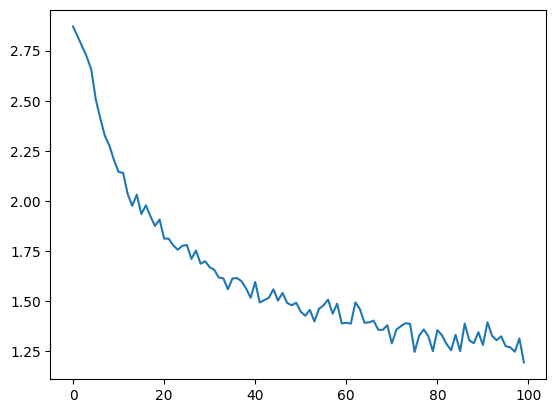

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

As we are performing a classification, a direct assessment of the goodness classification is the confusion matrix for every language. For this the network is frozen, and samples are run through the network to obtain a set of predictions, and then assess the correctness of the predictions.

/var/folders/3w/7v1njqbd2h10vfhnbwb23hth0000gn/T/ipykernel_10702/3585656379.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/3w/7v1njqbd2h10vfhnbwb23hth0000gn/T/ipykernel_10702/3585656379.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


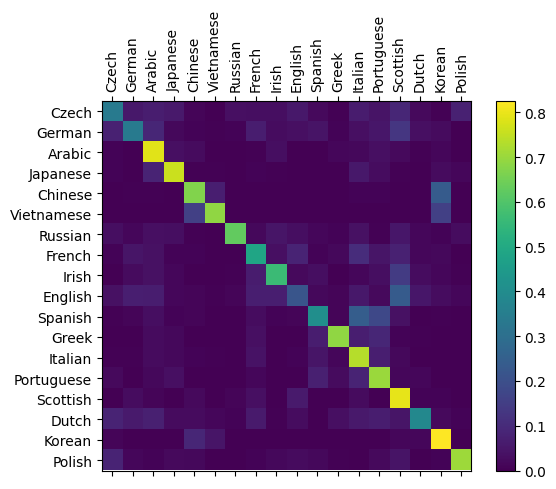

In [15]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

A more direct test of our trained model is then running it with a bunch of sample prompts

In [16]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Toshev')
predict('Paehler')
predict('Adams')


> Toshev
(-0.79) Russian
(-1.36) Korean
(-2.40) Vietnamese

> Paehler
(-0.60) German
(-2.11) English
(-2.37) Dutch

> Adams
(-0.29) Arabic
(-2.77) Portuguese
(-3.21) Japanese


## Tasks:

* a) Adapt this training to use the definitions of the RNN & LSTM we had in the lecture, train them, and compare the performance
* b) Repeat this training with PyTorch's native RNN-class
* c) Repeat this training with PyTorch's native LSTM-class
* d) Increase the size of the network and see how this alters the performance.